# Using Simulated Annealing With Neutral Atom Quantum Computer 

## Introduction

In this notebook, we explore a hybrid classical-quantum algorithm for solving an antenna placement optimization problem. The objective is to maximize the coverage of a region while minimizing interference between antennas. This problem involves a vast search space of possible antenna positions, which poses a significant computational challenge. To address this, we use a **Neutral Atom Quantum Computing (NAQC)** and classical **simulated annealing**, combining the strengths of quantum and classical computing.

### Problem Overview

A classical **Simulated Annealing (SA)** algorithm is an heuristic method used to solve complex optimization problems, such as our antenna placement problem. Simulated annealing simulates the physical process of heating a material and slowly lowering the temperature to minimize its energy (this can also be compraed to quantum annealing). In our context, SA enables a systematic exploration of the vast search space, iteratively refining candidate solutions by "cooling" the system. This iterative approach allows SA to escape local minima and explore globally optimal or near-optimal solutions efficiently, which is particularly advantageous for large-scale optimization.

### Quantum Advantage with NAQC

In an ideal scenario, if we could incorporate a high-resolution grid layout on a large NAQC register, we would simply select the **Maximum Weighted Independent Set (MWIS)** from a vast grid of possible positions, where each grid point represents an atom on the NAQC. However, our computational resources limit us to a maximum of 12 atoms, making it impractical to represent the full search space on the NAQC alone. 

To work around this, we use NAQC’s intrinsic ability to find independent sets by coupling it with **Simulated Annealing** , allowing us restrict the search space only to independent set configurations. Each iteration of the simulated annealing algorithm produces a new candidate grid layout, and we compute the **MIS** (Maximum Independent Set) on this layout using the NAQC. By doing so, we avoid the computational overhead of solving for MIS classically, which is slow and resource-intensive with traditional solvers like **GLPK**.

### Hybrid Classical-Quantum Workflow

The algorithm proceeds as follows:

1. **Grid Initialization**: We start with a random grid layout.
2. **Simulated Annealing Iteration**: At each iteration, we generate a new candidate layout by following the rules of simulated annealing.
3. **Quantum MIS Calculation**: Using the NAQC, we compute the MIS on the current grid layout, thereby focusing only on atoms that form an independent set and reducing unnecessary configurations.
4. **Optimization**: This hybrid approach allows us to efficiently explore high-coverage, low-interference layouts by exploiting NAQC’s strength in finding MIS configurations in each iteration.

This notebook provides an implementation of this approach, providing an efficient solution to the antenna placement problem.

**Note**: The pulse parameters have been previously optimized in another jupyter notebook for similar graph. We thus only import and use those parameters.


| Name                | Coverage | Antennas |
|---------------------|----------|----------|
| Bradleymouth        | 886      | 6        |
| Brandonberg         | 850      | 3        |
| Hansenchester       | 816      | 4        |
| Joshuachester       | 866      | 5        |
| New Rebeccaberg     | 845      | 6        |
| North Cal           | 847      | 3        |
| Nort Christopherbuty| 859      | 5        |
| North Joshua        | 746      | 4        |
| Port Jonathan       | 857      | 5        |
| Zacharyburgh        | 819      | 4        |
| **Total**           | **8391** | **45**   |
| **Average**         | **839.1**| **4.5**  |

## Import Required Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.optimize import dual_annealing
import scipy as scipy
from scipy.spatial import KDTree, distance_matrix
from scipy.spatial.distance import pdist
import json
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.waveforms import InterpolatedWaveform, RampWaveform, ConstantWaveform
from pulser.channels.dmm import DMM

## Define Problem Parameters

We first retrieve the population data, and plot its denisty in hexagonal bins

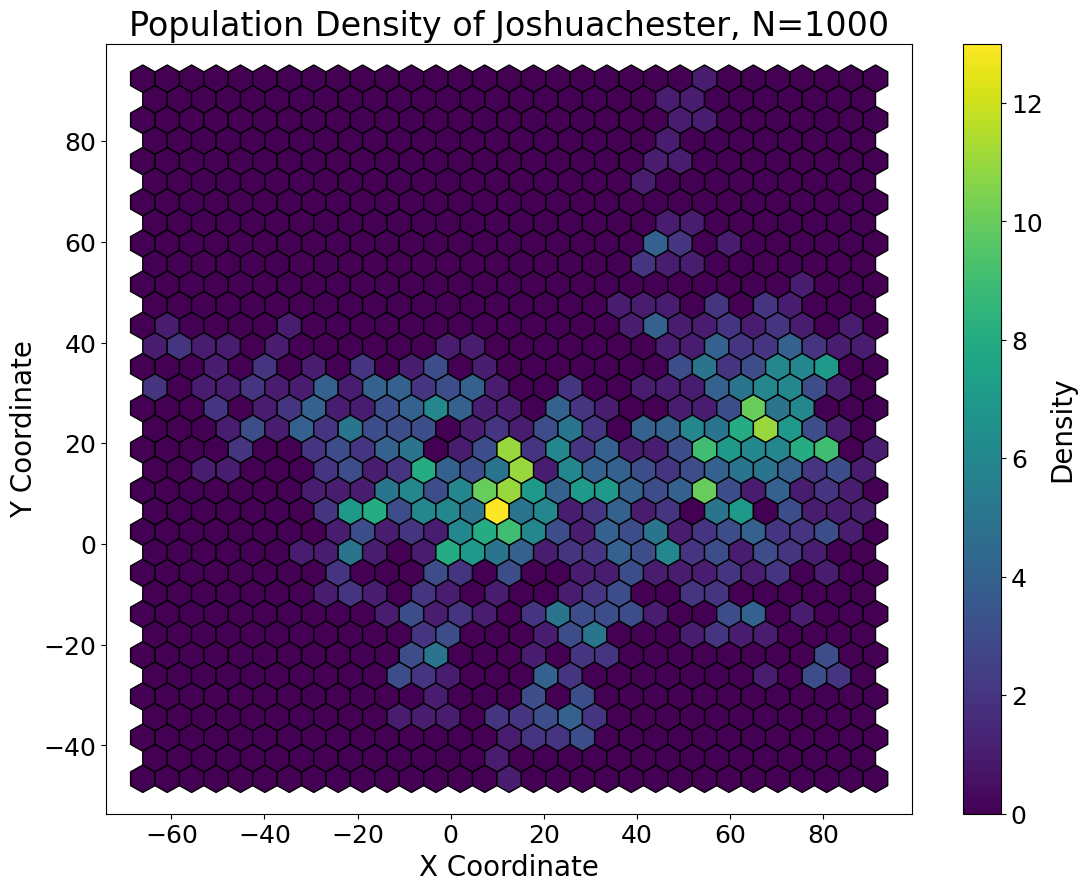

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']

city_name = cities[3]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.figure(figsize=(13, 10))
plt.hexbin(x, y, gridsize=30, cmap='viridis', edgecolors='black')
cbar = plt.colorbar(label='Density')
cbar.set_label('Density', fontsize=20)  
cbar.ax.tick_params(labelsize=18)       

# Add titles and labels
plt.title('Population Density of {}, N={}'.format(city_name, len(x)), fontsize=24)
plt.xlabel('X Coordinate', fontsize=20)
plt.ylabel('Y Coordinate', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

The coverage function to optimize $COV$ for $N$ antennas is given by :

$$
COV = \sum_{i \in N} d_R(i) - B \sum_{i,j \in A} \text{Interfere}(i, j)
$$

where:

$$
\text{Interfere}(i, j) = \begin{cases} 
1, & \text{if } ||\vec{r}_i - \vec{r}_j|| < 2R \\
0, & \text{otherwise}
\end{cases}
$$

with
- coverage radius $R$ = 25
- antenna position $\vec{r}_i$
- $d_R(i)$ the nb. of population points within radius R around $\vec{r}_i$
- interference for $d < 2R$
- maximum nb. of antennas = 70
- minimum coverage = 0.7 $\times$ #population

In [3]:
def evaluate_coverage_final(population_x, population_y, placement, R_dist):
    """
    Evaluates the coverage of a set of grid points, penalizing overlapping points.

    Parameters:
    - population_x, population_y: Coordinates of the population points.
    - placement: Array of (x, y) coordinates for the placement of antennas.
    - R_dist: Coverage radius of each antenna.

    Returns:
    - cost: Coverage score. A high positive score indicates good coverage without overlap,
            while a negative score indicates excessive overlap.
    """
    x = population_x
    y = population_y
    B = len(x)  # Number of population points
    coords = np.array([[x[i], y[i]] for i in range(len(x))])  # Array of population coordinates
    cost = 0  # Initialize the cost

    # Loop over each placement point to evaluate coverage and penalize overlaps
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])  # Current placement point

        # Check overlap with other placement points
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])  # Another placement point
            if i != j:  # Avoid self-comparison
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)  # Distance between points
                if dist <= 2* R_dist:  # Penalize if within overlap threshold
                    cost += -B  # Apply negative cost based on number of population points

        # Calculate coverage by checking distances to population points
        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)  # Count population points within coverage radius
        cost += cov  # Add coverage to the cost

    # Check if the total cost is negative, indicating excessive overlap
    if cost < 0:
        return -np.inf  # Return a very low score if there's excessive overlap
    else:
        return cost  # Otherwise, return the total coverage score

def simple_coverage(population_x, population_y, grid_points, R_antennas):
    """
    Calculates a coverage score for grid points based on their proximity to population points.
    (without taking inteference into account).

    Parameters:
    - population_x, population_y: Coordinates of the population points.
    - grid_points: Array of (x, y) coordinates for the antennas.
    - R_antennas: Coverage radius of each antenna.

    Returns:
    - cost: Coverage score. Higher values indicate better coverage. Antenna that covers nothing are penalized.
    """
    cost = 0  # Initialize coverage cost
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])  # Population coordinates

    # Loop over each grid point to calculate its coverage of the population
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])  # Current grid point
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)  # Distance to each population point

        truth_table = (dist <= R_antennas)  # Boolean array: True if within coverage radius
        cov = np.sum(truth_table)  # Count of population points within coverage radius

        # Penalize if grid point covers no population points
        if cov == 0:
            cost -= len(population_x) / 2  # Apply penalty for lack of coverage

        cost += cov  # Add the coverage count to the cost

    return cost  # Return the total coverage score

    

## Parameters for the NAQC

In [4]:
# Define population parameters
population_x = x  # X-coordinates of the population points
population_y = y  # Y-coordinates of the population points
offset = [population_x.min(), population_y.min()]  # Offset to start grid at the minimum x and y values
R_antennas = 25  # Operating radius for each antenna
max_grid_points = 8  # Maximum number of antennas (grid points)

# Initialize global variables for tracking the best solution
best_score = -1  # Initialize best score with a low value
list_best_grid_points = []  # List to store best grid point configurations
list_best_mis = []  # List to store MIS (Maximal Independent Sets) configurations
list_best_coverage = []  # List to store best coverage values
global_counter = 0  # Global counter for tracking iterations or conditions

# NAQC (Neutral Atom Quantum Computing) parameters
distance_treshold = 0.9 * R_antennas  # Minimum distance threshold between grid points
min_dist_register = 5  # Minimum distance for registering qubits in the configuration

# Load optimized pulse parameters from file
optimized_data = np.load('media/optimized_values.npz')
T = optimized_data['T'] # Total pulse duration
omega_max = optimized_data['omega_max'] # Maximum Rabi frequency
delta_0 = optimized_data['delta_0'] # Initial detuning
delta_f = optimized_data['delta_f'] # Final detuning
# Random instance of the parameter space
params = optimized_data['param']
m = (int)(len(params)/2) # Number of parameters for the ramp
amp_params = params[:m] # Amplitude parameters
det_params = params[m:] # Detuning parameters

N_samples = 1000 # Number of samples for the simulation

# Compile NAQC parameters into a dictionary for easy access
naqc_parameters_dict = {
    "min_dist_register": min_dist_register,  # Minimum distance for registering qubits
    "distance_treshold": distance_treshold,  # Minimum allowable distance between grid points
    "noiseless": None,  # Noiseless simulation configuration
    "noisy": SimConfig(  # Noisy simulation configuration for realistic conditions
        noise=("SPAM", "dephasing", "doppler"),  # Types of noise included
        eta=0.8,  # Detection efficiency
        temperature=1000,  # Temperature parameter for noise model
        runs=50,  # Number of runs for simulation
    )
}

## Utils functions for the algorithm

In [5]:
def select_points_with_min_distance(grid_points, min_dist):
    """
    This function acts as a constraint for the Simulated Annealing alogorithm
    It removes the points from the grid that do not respect the minimal distance
    pereventing any issues when simulating on the quantum register. 

    Parameters:
    - grid_points: Array of (x, y) coordinates for potential placement points.
    - min_dist: Minimum required distance between any two selected points.

    Returns:
    - selected_points: Array of selected points that satisfy the minimum distance constraint.
    """
    # Convert grid_points to a numpy array if it’s not already
    grid_points = np.array(grid_points)
    
    # Calculate pairwise distances between all grid points
    distances = distance_matrix(grid_points, grid_points)
    
    # Initialize a list to hold the indices of the selected points
    selected_indices = []
    
    # Create a set of indices representing the points that are still available for selection
    available_indices = set(range(len(grid_points)))
    
    # Loop until there are no available points left to consider
    while available_indices:
        # Select the first available point (arbitrary choice) and add its index to the selected list
        current_index = available_indices.pop()
        selected_indices.append(current_index)
        
        # Find all points within min_dist of the current point using the distance matrix
        close_points = np.where(distances[current_index] < min_dist)[0]
        
        # Remove these points from available_indices, as they are too close to the selected point
        available_indices.difference_update(close_points)
    
    # Gather the selected points based on the indices stored in selected_indices
    selected_points = grid_points[selected_indices]
    
    return selected_points

In [6]:
def embedding(grid_points, max_grid_points, distance_treshold, device_used, min_dist_register):
    """
    Embedding grid points into the quantum register.

    Parameters:
    - grid_points: Array of initial grid points.
    - max_grid_points: Maximum number of grid points to consider.
    - distance_treshold: Distance threshold for removing nearby grid points.
    - device_used: Device object used for specifying Rydberg blockade parameters.
    - min_dist_register: Minimum allowed distance in the register.

    Returns:
    - grid_points: Updated grid points array after removing close points.
    - max_grid_points: Updated number of grid points after filtering.
    - scaled_R: Scaled coverage radius based on the distance scaling factor.
    - scaled_coords: Scaled coordinates of the grid points.
    - reg: Register containing the final embedding of grid points.
    """
    # Reshape grid points to (num_points, 2) format for 2D coordinates
    grid_points = grid_points.reshape((max_grid_points, 2))
    
    # Initialize coordinates array and calculate the minimum pairwise distance
    coords = np.array(grid_points)
    val = np.min(pdist(coords))

    # Remove points that are too close based on distance threshold
    if val < distance_treshold:
        grid_points = select_points_with_min_distance(grid_points, distance_treshold)  # Filter close points
        max_grid_points = len(grid_points)  # Update the maximum grid points count
        coords = np.array(grid_points)  # Recompute coordinates
        val = np.min(pdist(coords))  # Recompute minimum distance

    # Scale coordinates to ensure a minimum distance of 'min_dist_register'
    factor = min_dist_register / val
    scaled_coords = coords * factor  # Scale coordinates to fit min_dist_register

    # Calculate Rydberg blockade radius and apply additional scaling factors
    rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
    scaled_R = 25 * factor  # Scale coverage radius based on distance factor
    factor_for_rydberg_scaling = rydberg_radius / (2 * scaled_R)
    scaled_R *= factor_for_rydberg_scaling  # Update scaled_R based on Rydberg scaling
    scaled_coords *= factor_for_rydberg_scaling  # Scale coordinates further if needed

    # Create a register with the final coordinates of the qubits
    qubits = dict(enumerate(scaled_coords))
    reg = Register(qubits)

    return grid_points, max_grid_points, scaled_R, scaled_coords, reg


def convert_to_indices(bitstring):
    """
    Converts a binary bitstring into a list of indices where the bit is '1'.

    Parameters:
    - bitstring: A string of '0's and '1's representing the binary state of nodes.

    Returns:
    - indices: List of indices where the bitstring has '1' (active nodes).
    """
    return [i for i, bit in enumerate(bitstring) if bit == '1']


In [7]:
def create_interp_pulse(amp_params, det_params):
    """
    Creates an interpolated pulse with specified amplitude and detuning parameters.

    Parameters:
    - amp_params: List of intermediate amplitude values to shape the pulse's amplitude waveform.
    - det_params: List of intermediate detuning values to shape the pulse's detuning waveform.

    Returns:
    - Pulse object with the specified amplitude and detuning waveforms and an initial phase of 0.
    """
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

def simulate_and_sample(grid_points, max_grid_points, device_used, naqc_parameters_dict, draw_register=False):
    """
    Embeds grid points, creates a Rydberg pulse sequence, and runs a simulation to generate sampled solutions.

    Parameters:
    - grid_points: Array of initial grid point coordinates.
    - max_grid_points: Maximum number of grid points allowed.
    - device_used: Device object used for specifying Rydberg blockade parameters.
    - naqc_parameters_dict: Dictionary containing parameters for the NAQC setup.

    Returns:
    - solution: List of sampled solutions, sorted by frequency.
    - grid_points: Updated grid points after embedding and scaling.
    """
    # Embed and scale grid points based on device and NAQC parameters
    grid_points, max_grid_points, scaled_R, scaled_coords, reg = embedding(
        grid_points, max_grid_points,
        naqc_parameters_dict["distance_treshold"], device_used,
        naqc_parameters_dict["min_dist_register"]
    )

    if(draw_register):
        reg.draw(
            blockade_radius=device_used.rydberg_blockade_radius(naqc_parameters_dict["omega_max"]),
            draw_half_radius=True,
            draw_graph=True,
        )

    # Step 1: Create a quantum sequence
    seq = Sequence(reg, device_used)  # Initialize a quantum sequence with the given register and device
    seq.declare_channel("ising", "rydberg_global")  # Declare a channel named "ising" for global Rydberg interactions
    
    # Step 2: Add an interpolated pulse to the sequence
    # The pulse parameters are split into two parts: the first m elements and the rest
    seq.add(create_interp_pulse(params[:m], params[m:]), "ising")  # Add pulse to the sequence based on input parameters
    
    # Step 3: Run the quantum simulation
    simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)  # Initialize the simulator with the sequence
    results = simulator.run(progress_bar=False)  # Run the simulation without displaying a progress bar
    
    # Step 4: Sample the final state from the results
    count_dict = results.sample_final_state(N_samples=N_samples)  # Sample the final state with N_samples
    
    # Step 5: Process and sort the sampled results
    # Create an ordered dictionary of the most frequent results, keeping only those with more than 10 occurrences
    most_frequent = {k: v for k, v in count_dict.items() if v > 10}
    solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

    return solution, grid_points


def calculate_coverage_score(solution, grid_points, population_x, population_y, R_antennas):
    """
    Calculates the best coverage score from the given solutions, ensuring independent set (IS) constraints.

    Parameters:
    - solution: List of sampled solutions.
    - grid_points: Array of grid points.
    - population_x, population_y: Coordinates of the population points.
    - R_antennas: Coverage radius for each grid point.

    Returns:
    - coverage: Best coverage score found among solutions.
    - best_solution_points: Grid points corresponding to the best coverage score.
    """
    max_iter = min(len(solution), 6)  # Limit to the first 6 solutions
    real_R = 25
    coverage = -1
    best_coverage_index = 0

    # Loop over each solution to find the best coverage that also satisfies IS requirements
    for i in range(max_iter):
        selected_nodes = convert_to_indices(solution[i])
        solution_i_points = [grid_points[j] for j in selected_nodes]
        if len(solution_i_points) == 0:
            continue

        # Calculate coverage of the selected points
        coverage_i = simple_coverage(population_x, population_y, solution_i_points, real_R)

        # Check if the node set is an independent set (IS)
        check = KDTree(solution_i_points).query_pairs(2 * real_R + 1e-3)
        if len(check) > 0:  # If any points are closer than real_R, skip this solution
            continue

        # Update the best coverage if the current solution is better
        if coverage_i > coverage:
            coverage = coverage_i
            best_coverage_index = i
    try:
        # Retrieve the best solution points based on IS and coverage
        best_solution_indices = convert_to_indices(solution[best_coverage_index])
        best_solution_points = [grid_points[j] for j in best_solution_indices]
        return coverage, best_solution_indices
    except:
        return -1000, [] # in case the iteration does not provide an IS in the first 6, skip this iteration

def best_score_of_graph(grid_points, population_x, population_y, R_antennas, max_grid_points, print_results=True, draw_register=False):
    """
    Combines simulation and coverage scoring to find the best score for grid placement.
    Updates global best solution if a new best coverage is found.

    Parameters:
    - grid_points: Array of initial grid point coordinates.
    - population_x, population_y: Coordinates of the population points.
    - R_antennas: Coverage radius for each grid point.
    - max_grid_points: Maximum number of grid points allowed.

    Returns:
    - Negative score for coverage optimization; higher coverage results in a lower (more negative) score.
    """
    global best_score, list_best_grid_points, list_best_mis, list_best_coverage, global_counter

    global_counter += 1
    
    # Simulate and sample solutions
    device_used = pulser.devices.MockDevice
    solution, grid_points = simulate_and_sample(grid_points, max_grid_points, device_used, naqc_parameters_dict, draw_register)
    
    # Calculate the best coverage score from the sampled solutions
    coverage, best_solution_points = calculate_coverage_score(solution, grid_points, population_x, population_y, R_antennas)

    # Update global best score and records if the current coverage is the highest
    if coverage > best_score:
        best_score = coverage
        list_best_grid_points.append(grid_points)
        list_best_mis.append(best_solution_points)
        list_best_coverage.append((global_counter, coverage))

    if print_results:
        print(f'Coverage: {coverage}')
        print(f'Best coverage: {best_score}')
    
    # Return negative coverage score for minimization (higher coverage = lower score)
    return -coverage


## Optimization using SA

In [8]:
# Define the initial grid and parameters for antenna placement
population_x = x  # Population x-coordinates
population_y = y  # Population y-coordinates
R_antennas = 25  # Operating radius for each antenna

# Calculate offsets to define search bounds, adding 10% buffer around the population area
bounds_offset_x = np.abs(population_x.max() - population_x.min()) / 10
bounds_offset_y = np.abs(population_y.max() - population_y.min()) / 10

# Define bounds for the simulated annealing search space
bounds = (
    [(population_x.min() - bounds_offset_x, population_x.max() + bounds_offset_x)] * max_grid_points +
    [(population_y.min() - bounds_offset_y, population_y.max() + bounds_offset_y)] * max_grid_points
)

# Initialize variables to track the best score and solutions found during optimization
best_score = -1
list_best_grid_points = []
list_best_mis = []
list_best_coverage = []
global_counter = 0

# Flags for additional functionalities (e.g., printing, drawing)
printer = False
draw_register = False

# Run the simulated annealing optimization to find the best grid points placement
result = dual_annealing(
    func=best_score_of_graph,     # Objective function to minimize (negative coverage score)
    args=(population_x, population_y, R_antennas, max_grid_points, printer, draw_register),
    bounds=bounds,                # Search bounds for grid points coordinates
    initial_temp=100.0,           # Initial temperature; lower values lead to smaller initial moves (default: 5230.0)
    restart_temp_ratio=1e-6,      # Temperature ratio for restarting the annealing process (default: 2e-5)
    visit=1.5,                    # Controls step size; lower values make smaller, more precise moves (default: 2.62)
    accept=-1.0,                  # Acceptance parameter; less negative for stricter acceptance of worse solutions (default: -5.0)
    maxfun=1000,                   # Maximum number of function evaluations (default: 1e7)
    no_local_search=True,         # Disables local search phase for broader exploration (default: False)
    seed=42,                      # Random seed for reproducibility (default: None)
)

KeyboardInterrupt: 

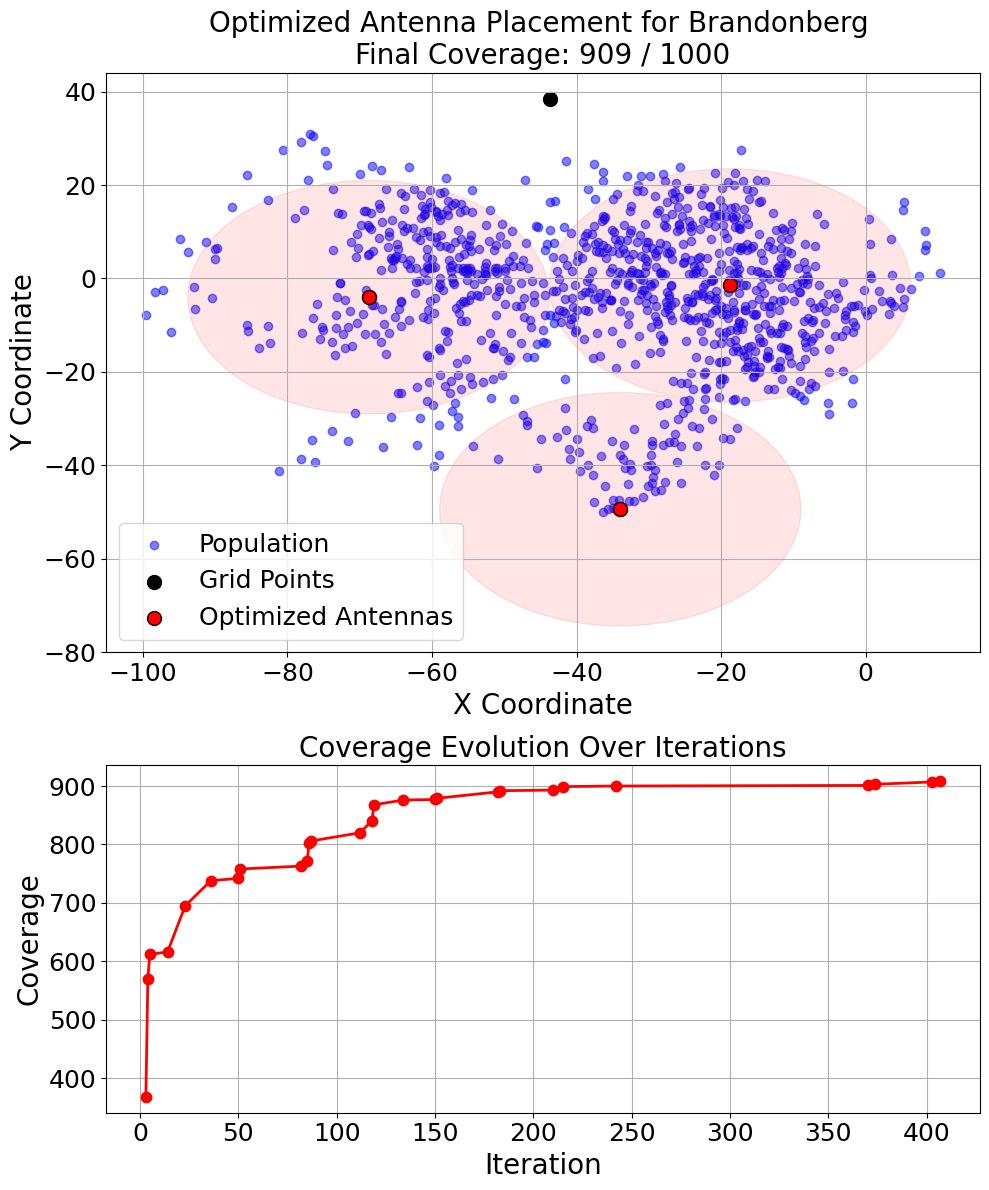

Final coverage: 909
Real coverage: 909 out of 1000


In [ ]:
# Extract iteration and score data for the coverage evolution plot
it, list_best_scores = zip(*list_best_coverage)

# Create a figure with 2 vertically stacked subplots with different height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 1.2]})

# Plot 1: Coverage Evolution Over Iterations
ax2.plot(it, list_best_scores, marker='.', color='red', markersize=15, linewidth=2)
ax2.set_xlabel('Iteration', fontsize=20)
ax2.set_ylabel('Coverage', fontsize=20)
ax2.set_title('Coverage Evolution Over Iterations', fontsize=20)
ax2.tick_params(axis='both', labelsize=18)
ax2.grid(True)

# Extract the positions of the MIS nodes
best_grid_points = list_best_grid_points[-1]
best_mis = list_best_mis[-1]
final_positions = best_grid_points[best_mis]

# Calculate coverage scores
score = evaluate_coverage_final(population_x, population_y, final_positions, R_antennas)
real_coverage = simple_coverage(population_x, population_y, final_positions, R_antennas)

# Plot 2: Optimized Grid and Population
ax1.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
ax1.scatter(best_grid_points[:, 0], best_grid_points[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
ax1.scatter(final_positions[:, 0], final_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')

# Add coverage circles around each optimized antenna
for pos in final_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    ax1.add_patch(circle)

# Set font sizes and labels
ax1.set_xlabel('X Coordinate', fontsize=20)
ax1.set_ylabel('Y Coordinate', fontsize=20)
ax1.set_title(f'Optimized Antenna Placement for {city_name} ' + f'\nFinal Coverage: {real_coverage} / {len(population_x)}', fontsize=20)
ax1.legend(fontsize=18)
ax1.tick_params(axis='both', labelsize=18)

ax1.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"figures/city_{city_name.replace(' ', '_')}.png", dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()

# Print final coverage values for reference
score = evaluate_coverage_final(population_x, population_y, final_positions, R_antennas)
print('Final coverage:', score)
print(f'Real coverage: {real_coverage} out of {len(population_x)}')



In [ ]:
# Plotting function for the animation
def update(frame):
    plt.clf()  # Clear the current figure to update the plot
    grid_points = list_best_grid_points[frame]
    coverage = list_best_coverage[frame][1]
    mis_positions = grid_points[list_best_mis[frame]]

    plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
    plt.scatter(mis_positions[:, 0], mis_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')
    for pos in mis_positions:
        circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
        plt.gca().add_patch(circle)
    plt.title(f"Iteration {frame + 1}, Coverage: {coverage:.4f}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()

# Params for animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

# Create the animation
anim = FuncAnimation(
    fig, update, frames=len(list_best_grid_points),
    interval=100, repeat=False
)

# Save the animation as a GIF
anim.save('media/iteration_evolution_{}.gif'.format(city_name), writer='pillow', fps=1)


# Display the GIF (optional)
HTML(f'<img src="iteration_evolution_{city_name}.gif")>')